In [1]:
from pymongo import MongoClient
import datetime
import pandas as pd
import numpy as np
import itertools
import pymongo
from wordcloud import WordCloud

from collections import Counter
import pickle
from gensim.models.doc2vec import Doc2Vec, LabeledSentence
import matplotlib.pyplot as plt
import seaborn as sns

client = MongoClient("localhost", 27017)
db = client["reddit_polarization"]
sw = pickle.load(open("stoplist.pickle"))

Load trained `doc2vec` model

In [2]:
model = Doc2Vec.load("doc2vec_dbow_d100_n5_w15_s1e_05_t4.model")

Load words with computed zscores

In [3]:
zscore = pickle.load(open("zscore.pickle"))

Helper function for computing summary of author posts information

In [4]:
def agg_author(df):
    men_mean_score = df[df["subreddit"] == "MensRights"]["score"].mean()
    men_min_score = df[df["subreddit"] == "MensRights"]["score"].min()
    men_max_score = df[df["subreddit"] == "MensRights"]["score"].max()
    men_count = df[df["subreddit"] == "MensRights"]["score"].shape[0]
    
    fem_mean_score = df[df["subreddit"] == "Feminism"]["score"].mean()
    fem_min_score = df[df["subreddit"] == "Feminism"]["score"].min()
    fem_max_score = df[df["subreddit"] == "Feminism"]["score"].max()
    fem_count = df[df["subreddit"] == "Feminism"]["score"].shape[0]
    
    return pd.Series([men_mean_score, men_min_score, men_max_score, men_count,
                      fem_mean_score, fem_min_score, fem_max_score, fem_count],
                     index=["men_mean_score", "men_min_score", "men_max_score", "men_count",
                            "fem_mean_score", "fem_min_score", "fem_max_score", "fem_count"])

In [5]:
men = pd.DataFrame(list(db["MensRights"].find({}, {"author": 1, "score": 1, "subreddit": 1, "_id": 0})))
fem = pd.DataFrame(list(db["Feminism"].find({}, {"author": 1, "score": 1, "subreddit": 1, "_id": 0})))
print men.shape, fem.shape

(2452716, 3) (213100, 3)


In [6]:
author_info = pd.concat([men, fem], axis=0)

In [7]:
authors = author_info.groupby("author").apply(agg_author)

Helper function for computing polarized author groups (e.g. subreddit-only and crossposters)

In [8]:
def polarized_authors(authors, size=2000):
    men_author = authors[authors["men_mean_score"].notnull()][["men_mean_score", "men_min_score",
                                                               "men_max_score", "men_count"]]
    men_author = men_author.reset_index()
    
    fem_author = authors[authors["fem_mean_score"].notnull()][["fem_mean_score", "fem_min_score",
                                                               "fem_max_score", "fem_count"]]
    fem_author = fem_author.reset_index()
    
    # `men_author`: users who posted >= 1 post in `r/MensRights`
    # `fem_author`: users who posted >= 1 post in `r/Feminism`
    # `df`: cross-posters
    df = men_author.merge(fem_author, left_on="author", right_on="author")
    
    men_polar = pd.DataFrame(df[(df["men_min_score"] > 0) & (df["fem_max_score"] <= 0)])
    men_polar = men_polar[["author"]]
    
    fem_polar = pd.DataFrame(df[(df["fem_min_score"] > 0) & (df["men_max_score"] <= 0)])
    fem_polar = fem_polar[["author"]]
    
    men_only = set(men_author["author"]) - set(fem_author["author"])
    fem_only = set(fem_author["author"]) - set(men_author["author"])
    
    men_only = pd.DataFrame(men_author[men_author["author"].isin(men_only)])
    fem_only = pd.DataFrame(fem_author[fem_author["author"].isin(fem_only)])
 
    men_only = men_only.sort_values("men_max_score", ascending=False)
    men_only = men_only[:len(men_polar)]
    men_only = men_only[["author"]]

    fem_only = fem_only.sort_values("fem_max_score", ascending=False)
    fem_only = fem_only[:len(fem_polar)]
    fem_only = fem_only[["author"]]
    
#    men_train = set(men_polar["author"]) | set(men_only["author"])
#    fem_train = set(fem_polar["author"]) | set(fem_only["author"])
    
#    men_train = pd.DataFrame(men_author[men_author["author"].isin(men_train)])
#    fem_train = pd.DataFrame(fem_author[fem_author["author"].isin(fem_train)])
    
    return men_polar, fem_polar, men_only, fem_only

In [9]:
def get_post_of_author(row, subreddit, field, min_word):
    author = row["author"]
    
    post_by_author = list(db[subreddit].find({"author": author}, {field: 1, "score": 1, "_id": 0}))
    post_by_author = map(lambda post: {"score": post["score"], field: clean_token_pos(post[field])}, post_by_author)
    post_by_author = filter(lambda post: len(post[field].split(" ")) >= min_word, post_by_author)
    post_by_author = sorted(post_by_author, key=lambda post: -post["score"])
    post_by_author = [(" ".join([subreddit, author, str(i)]),
                       post_by_author[i]["score"],
                       post_by_author[i][field])
                      for i in range(len(post_by_author))]
    
    return post_by_author

In [28]:
men_polar, fem_polar, men_only, fem_only = polarized_authors(authors, size=200)

In [29]:
men_polar.shape, fem_polar.shape, men_only.shape, fem_only.shape

((278, 1), (238, 1), (278, 1), (238, 1))

In [30]:
men_polar[:3]

,author
6,0Fsgivin
8,0mudkipz
12,115935


In [31]:
fem_polar[:3]

,author
34,27182818284
65,5bits
75,6degreestoBillMurray


In [32]:
men_only[:3]

,author
104569,suicidalgod
38496,PuckyMacpuckpants
12523,DavidByron2


In [33]:
fem_only[:3]

,author
9173,Our-Year
21323,its_all_too_much
26381,psychologyst


Retrieve post from authors, and each author is represented by the post with **top score** in the author's **home** subreddit

In [34]:
def pos_filter(x, keep=set("NJ")):
    if len(x) == 0:
        return ""
    
    tokens_pos = x.split(" ")
    tokens_pos = map(lambda pair: pair.split("/"), tokens_pos)
    
    tokens_pos = filter(lambda pair: pair[1] in keep, tokens_pos)

    if len(tokens_pos) == 0:
        return ""
    
    return " ".join(zip(*tokens_pos)[0])

def clean_token_pos(text):
    text = pos_filter(text)
    out = " ".join(filter(lambda x: x not in sw, text.split(" ")))
    return out

In [35]:
men_polar["post"] = men_polar.apply(lambda row:
                                    get_post_of_author(row, "MensRights", "tokens_njv_pos", 10), axis=1)

fem_polar["post"] = fem_polar.apply(lambda row:
                                    get_post_of_author(row, "Feminism", "tokens_njv_pos", 10), axis=1)

men_polar = men_polar[men_polar["post"].map(len) > 0]
fem_polar = fem_polar[fem_polar["post"].map(len) > 0]

In [36]:
men_only["post"] = men_only.apply(lambda row:
                                    get_post_of_author(row, "MensRights", "tokens_njv_pos", 10), axis=1)

fem_only["post"] = fem_only.apply(lambda row:
                                    get_post_of_author(row, "Feminism", "tokens_njv_pos", 10), axis=1)

men_only = men_only[men_only["post"].map(len) > 0]
fem_only = fem_only[fem_only["post"].map(len) > 0]

In [37]:
men_polar.shape, fem_polar.shape, men_only.shape, fem_only.shape

((151, 2), (115, 2), (254, 2), (197, 2))

In [38]:
men_polar[:3]

,author,post
6,0Fsgivin,"[(MensRights 0Fsgivin 0, 1, yah bullshit men s..."
69,5panks,"[(MensRights 5panks 0, 5, equal opportunity eq..."
114,ARustyFirePlace,"[(MensRights ARustyFirePlace 0, 3, tear keyboa..."


In [39]:
fem_polar[:3]

,author,post
34,27182818284,"[(Feminism 27182818284 0, 10, hard twitter scu..."
84,8spd,"[(Feminism 8spd 0, 4, soviet tank ussr cold wa..."
295,ArchangelleWeezyelle,"[(Feminism ArchangelleWeezyelle 0, 1, divide c..."


In [40]:
men_only[:3]

,author,post
104569,suicidalgod,"[(MensRights suicidalgod 0, 5, fantasm big par..."
38496,PuckyMacpuckpants,"[(MensRights PuckyMacpuckpants 0, 2376, judge ..."
12523,DavidByron2,"[(MensRights DavidByron2 0, 2332, male usa sex..."


In [41]:
fem_only[:3]

,author,post
21323,its_all_too_much,"[(Feminism its_all_too_much 0, 279, woman femi..."
26381,psychologyst,"[(Feminism psychologyst 0, 265, wide range bod..."
17293,cupcakesandpotter,"[(Feminism cupcakesandpotter 0, 238, misogyny ..."


Helper function for finding the document embedding vector for each author's top scoring post

In [42]:
def docvecs_of_author(row):    
    text = row["post"][0][2]
    return pd.Series([model.infer_vector(text.split(" "))])

In [43]:
men_polar["vec"] = men_polar.apply(lambda row: docvecs_of_author(row), axis=1)
fem_polar["vec"] = fem_polar.apply(lambda row: docvecs_of_author(row), axis=1)
men_only["vec"] = men_only.apply(lambda row: docvecs_of_author(row), axis=1)
fem_only["vec"] = fem_only.apply(lambda row: docvecs_of_author(row), axis=1)

Computing the center (i.e. arithmetic avearge) of the word vectors of **words overrepresented** in either subreddit

In [44]:
fem_specific_word = zscore[["word"]][:50]
men_specific_word = zscore[["word"]][-50:]

In [47]:
def word_vec(row):
    return pd.Series([model[row["word"]]])

In [48]:
men_specific_word["vec"]= men_specific_word.apply(lambda row: word_vec(row), axis=1)
fem_specific_word["vec"]= fem_specific_word.apply(lambda row: word_vec(row), axis=1)

In [49]:
men_specific_word_vec = np.array([v for v in men_specific_word["vec"]]).mean(axis=0)
fem_specific_word_vec = np.array([v for v in fem_specific_word["vec"]]).mean(axis=0)

Perform the **t-SNE embedding** for vizualization

In [50]:
X_men_polar = np.array([v for v in men_polar["vec"]])
X_fem_polar = np.array([v for v in fem_polar["vec"]])
X_men_only = np.array([v for v in men_only["vec"]])
X_fem_only = np.array([v for v in fem_only["vec"]])

In [51]:
X_men_polar.shape, X_fem_polar.shape, X_men_only.shape, X_fem_only.shape

((151, 100), (115, 100), (254, 100), (197, 100))

In [52]:
X = np.r_[X_men_polar, X_fem_polar, men_specific_word_vec[np.newaxis, :],
          fem_specific_word_vec[np.newaxis, :], X_men_only, X_fem_only]

In [53]:
X.shape

(719, 100)

In [54]:
from sklearn.manifold import TSNE

In [61]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

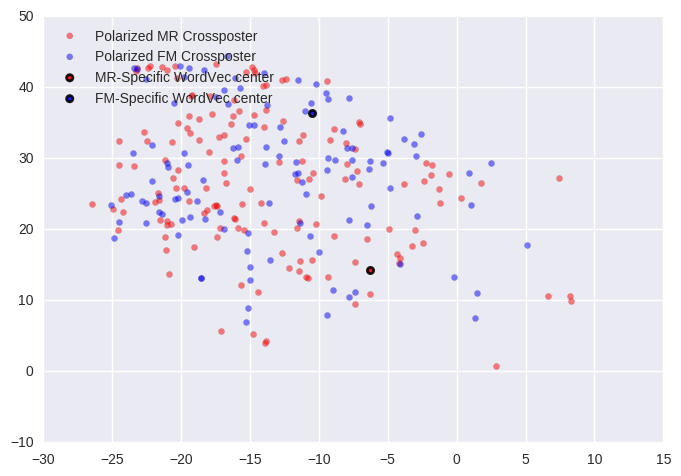

In [62]:
plt.scatter(X_tsne[:151, 0], X_tsne[:151, 1], c="r", alpha=0.5, linewidths=0.1)
plt.scatter(X_tsne[151:151+115, 0], X_tsne[151:151+115, 1], c="b", alpha=0.5, linewidths=0.1)
plt.scatter(X_tsne[151+115, 0], X_tsne[151+115, 1], c="r", alpha=0.9, linewidths=2)
plt.scatter(X_tsne[-(254+197), 0], X_tsne[-(254+197), 1], c="b", alpha=0.9, linewidths=2)
plt.legend(["Polarized MR Crossposter", "Polarized FM Crossposter", "MR-Specific WordVec center", "FM-Specific WordVec center"], loc=2)
plt.show()

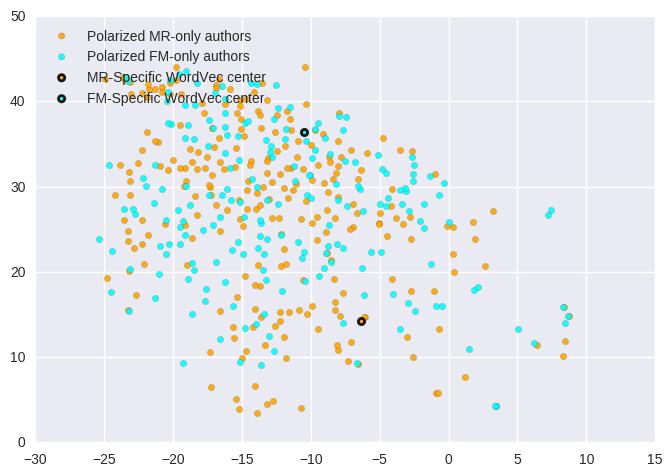

In [63]:
plt.scatter(X_tsne[-(254+197):-197, 0], X_tsne[-(254+197):-197, 1], c="orange", alpha=0.9, linewidths=0.1)
plt.scatter(X_tsne[-197:, 0], X_tsne[-197:, 1], c="cyan", alpha=0.9, linewidths=0.1)
plt.scatter(X_tsne[151+115, 0], X_tsne[151+115, 1], c="orange", alpha=0.9, linewidths=2)
plt.scatter(X_tsne[-(254+197), 0], X_tsne[-(254+197), 1], c="cyan", alpha=0.9, linewidths=2)
plt.legend(["Polarized MR-only authors", "Polarized FM-only authors", "MR-Specific WordVec center", "FM-Specific WordVec center"], loc=2)
plt.show()